In [8]:
import pandas as pd
import geopandas as gpd
import os

import matplotlib.pyplot as plt
import geopandas as gpd

import rasterio
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
from itertools import compress
from dbfread import DBF

In [2]:
corinePath = os.path.join("Z:\\", "Masterarbeit_Marius", "CORINE_data_Germany", "clc5")
corinePath

'Z:\\Masterarbeit_Marius\\CORINE_data_Germany\\clc5'

In [3]:
corineFiles = []
for file in os.listdir(corinePath):
    if file.endswith(".shp"):
        corineFiles.append(file)
        print("Found ", os.path.join(corinePath, file))

Found  Z:\Masterarbeit_Marius\CORINE_data_Germany\clc5\clc5_class4xx.shp
Found  Z:\Masterarbeit_Marius\CORINE_data_Germany\clc5\clc5_class2xx.shp
Found  Z:\Masterarbeit_Marius\CORINE_data_Germany\clc5\clc5_class5xx.shp
Found  Z:\Masterarbeit_Marius\CORINE_data_Germany\clc5\clc5_class1xx.shp
Found  Z:\Masterarbeit_Marius\CORINE_data_Germany\clc5\clc5_class3xx.shp


In [5]:
corineFiles

['clc5_class4xx.shp',
 'clc5_class2xx.shp',
 'clc5_class5xx.shp',
 'clc5_class1xx.shp',
 'clc5_class3xx.shp']

In [6]:
polygonFrame = gpd.read_file(os.path.join(corinePath, corineFiles[1]))

<Axes: >

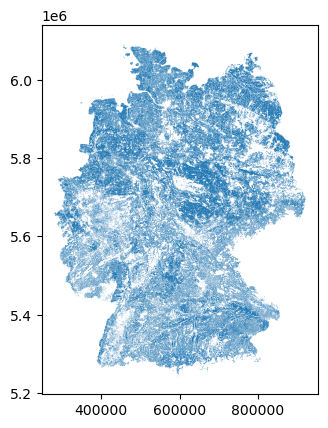

In [7]:
polygonFrame.plot()

In [3]:
raster_dir = "F:\\Persönliches\\Git\\BioOTon\\u2018_clc2018_v2020_20u1_raster100m\\DATA"

In [4]:
raster = "clcclip.tif"
dbf_file = "U2018_CLC2018_V2020_20u1.tif.vat.dbf"
raster_file = os.path.join(raster_dir, raster)
dbf_file = os.path.join(raster_dir, dbf_file)

In [5]:
dbf_data = DBF(dbf_file)
vat_df = pd.DataFrame(iter(dbf_data))
print("VAT DataFrame:\n", vat_df.head())

VAT DataFrame:
    Value       Count                                      LABEL3       Red  \
0      1    800699.0                     Continuous urban fabric  0.901961   
1      2  17085234.0                  Discontinuous urban fabric  1.000000   
2      3   3210212.0              Industrial or commercial units  0.800000   
3      4    414626.0  Road and rail networks and associated land  0.800000   
4      5    122685.0                                  Port areas  0.901961   

      Green      Blue CODE_18  
0  0.000000  0.301961     111  
1  0.000000  0.000000     112  
2  0.301961  0.949020     121  
3  0.000000  0.000000     122  
4  0.800000  0.800000     123  


In [8]:
soundscape_file = os.path.join("Z:\\Audio_data\\Dawn_chorus_raw_data", "dawn-chorus-soundscape.parquet")
sound_df = pd.read_parquet(soundscape_file)

In [ ]:
sound_df = sound_df[["id", "lat", "lng"]]

In [18]:
sound_gdf = gpd.GeoDataFrame(
    sound_df, geometry=gpd.points_from_xy(sound_df.lng, sound_df.lat), crs="EPSG:4326"
)

In [19]:
sound_gdf.to_crs("EPSG:3035", inplace=True)

In [20]:
sound_gdf.drop(["lat", "lng"], axis=1,inplace=True)

In [9]:
def getSoundLocations(dir):
    dir_files = os.listdir(dir)
    soundscape_file = os.path.join(dir, list(compress(dir_files, [file.endswith(".parquet") for file in dir_files]))[0])
    sound_df = pd.read_parquet(soundscape_file)

    sound_df = sound_df[["id", "lat", "lng"]]

    sound_gdf = gpd.GeoDataFrame(
        sound_df, geometry=gpd.points_from_xy(sound_df.lng, sound_df.lat), crs="EPSG:4326"
    )

    sound_gdf.to_crs("EPSG:3035", inplace=True)

    sound_gdf.drop(["lat", "lng"], axis=1,inplace=True)

    return sound_gdf

def getCorine(dir):
    dir_files = os.listdir(dir)
    raster_file = os.path.join(dir, list(compress(dir_files, [file.endswith("clip.tif") for file in dir_files]))[0])
    dbf_file = os.path.join(dir, list(compress(dir_files, [file.endswith("vat.dbf") for file in dir_files]))[0])

    # Get DBF File
    dbf_data = DBF(dbf_file)
    dbf_df = pd.DataFrame(iter(dbf_data))

    # Load Raster
    with rasterio.open(raster_file) as src:
        image = src.read(1)
        
        # Get the coordinate reference system (CRS) and transform
        crs = src.crs
        transform = src.transform
        nodata = src.nodata
        
        # Create geometries for raster
        all_shapes = shapes(image, transform=transform)
        
        # Create dictionary with geometries and corresponding values
        geoms = [
            {'value': value, 'geometry': shape(geom)}
            for geom, value in all_shapes 

            # Filter out no data
            # Implementation leads to unwanted gaps
            # if value != src.nodata
        ]

        raster_gdf = gpd.GeoDataFrame(geoms, crs=crs)

    joined_df = raster_gdf.join(dbf_df, on = "value")

    return joined_df

def getRecordingNeighbourhood(sound_point, corine_df, distance=200):

    buffer = gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").buffer(distance)[0]

    return [sound_point, corine_df[corine_df.intersects(buffer)]]


In [9]:
dir = "Z:\\Audio_data\\Dawn_chorus_raw_data"
points = getSoundLocations(dir)

<Axes: >

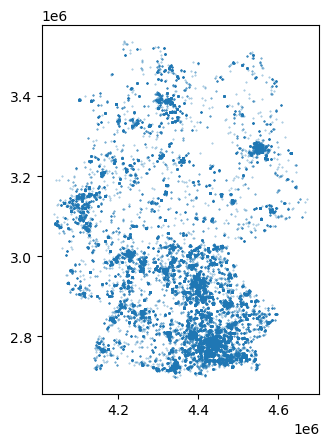

In [8]:
points.plot(markersize = 0.15, alpha= 0.55)

In [10]:
sound_point = points.iloc[100]
sound_point

id                                              9835572
geometry    POINT (4053981.945062326 3073699.565136006)
Name: 100, dtype: object

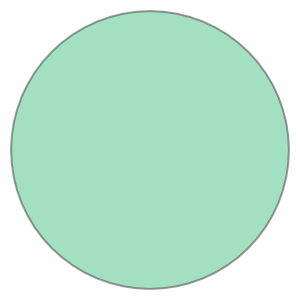

In [11]:
buffer = gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").buffer(200)
buffer[0]

In [ ]:
### Get Single point for now
### Implement numpy for faster processing?
# Later: Change algorithm so that image gets only loaded once
# Return count for each class and weigh
# Weigh closer cells more (Might need to change approach a bit in order to take raster cells instead of distance)
# Join original Dataframe, with count

In [12]:
def getCorineLocationsSingle(dir, buffer, distance=200):
    dir_files = os.listdir(dir)

    raster_file = os.path.join(dir, list(compress(dir_files, [file.endswith("clip.tif") for file in dir_files]))[0])
    dbf_file = os.path.join(dir, list(compress(dir_files, [file.endswith("vat.dbf") for file in dir_files]))[0])

    # Get DBF File
    dbf_data = DBF(dbf_file)
    dbf_df = pd.DataFrame(iter(dbf_data))

    print("Loading raster.")
    with rasterio.open(raster_file) as tif:
        print("Loaded raster successfully. ")
        raster_crs = tif.crs

        # Reproject buffer
        if buffer.crs != raster_crs:
            print("Reprojecting buffer due to differing SRS.")
            buffer = buffer.to_crs(raster_crs)

        # Mask raster to buffer
        image_data, transformed_data = mask(
            dataset=tif,
            shapes=buffer.geometry.tolist(),
            crop=True,
            all_touched=True 
        )

        print("Clipped raster.")

        print("Generating individual pixels.")

        # Get shape
        rows, cols = image_data.shape[1:]

        # Flatten image to a single band
        pixel_values = image_data[0].flatten()

        # Create arrays of all row and column indices
        col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))
        flattened_col_indices = col_indices.flatten()
        flattened_row_indices = row_indices.flatten()

        # # Get raster resolution to compute pixel size
        x_res = abs(transformed_data.a)
        y_res = abs(transformed_data.e)

        # Calculate NW corner of the pixels
        x_ul, y_ul = transformed_data * (flattened_col_indices, flattened_row_indices)

        # North-East (NE) corner
        x_ne = x_ul + x_res
        y_ne = y_ul

        # South-East (SE) corner
        x_se = x_ul + x_res
        y_se = y_ul - y_res # Note: Assuming a north-up, y-decreasing transform

        # South-West (SW) corner
        x_sw = x_ul
        y_sw = y_ul - y_res

        # Define pixel corners in counter-clockwise order:

        geometries = [
            Polygon([
                (x_ul[i], y_ul[i]),  # NW
                (x_ne[i], y_ne[i]),  # NE
                (x_se[i], y_se[i]),  # SE
                (x_sw[i], y_sw[i]),  # SW
                (x_ul[i], y_ul[i])   # NW (Close the ring)
            ])
            for i in range(len(x_ul))
        ]

        # Create geodataframe
        gdf = gpd.GeoDataFrame(
            pd.DataFrame({
                'value': pixel_values,
            }),
            geometry=geometries,
            crs=raster_crs
        )

        # Join geodataframe with CLC
        print("Joining with CLC")
        jdf = gdf.join(dbf_df, on = "value")

        # Get only intersecting pixels
        intersection_result = jdf.intersects(buffer.unary_union)
        
    return jdf[intersection_result]
    

In [13]:
jdf = getCorineLocationsSingle("F:\\Persönliches\\Git\\BioOTon", buffer)

Loading raster.
Loaded raster successfully. 
Clipped raster.
Generating individual pixels.
Joining with CLC


In [14]:
jdf

,value,geometry,Value,Count,LABEL3,Red,Green,Blue,CODE_18
1,2,"POLYGON ((4053800.000 3073900.000, 4053900.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121
2,18,"POLYGON ((4053900.000 3073900.000, 4054000.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
3,18,"POLYGON ((4054000.000 3073900.000, 4054100.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
4,18,"POLYGON ((4054100.000 3073900.000, 4054200.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
5,2,"POLYGON ((4053700.000 3073800.000, 4053800.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121
6,2,"POLYGON ((4053800.000 3073800.000, 4053900.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121
7,18,"POLYGON ((4053900.000 3073800.000, 4054000.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
8,18,"POLYGON ((4054000.000 3073800.000, 4054100.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
9,18,"POLYGON ((4054100.000 3073800.000, 4054200.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
10,2,"POLYGON ((4053700.000 3073700.000, 4053800.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121


In [16]:
intersection_result = jdf.intersects(buffer.unary_union)
jdf[intersection_result]

,value,geometry,Value,Count,LABEL3,Red,Green,Blue,CODE_18
1,2,"POLYGON ((4053800.000 3073900.000, 4053900.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121
2,18,"POLYGON ((4053900.000 3073900.000, 4054000.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
3,18,"POLYGON ((4054000.000 3073900.000, 4054100.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
4,18,"POLYGON ((4054100.000 3073900.000, 4054200.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
5,2,"POLYGON ((4053700.000 3073800.000, 4053800.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121
6,2,"POLYGON ((4053800.000 3073800.000, 4053900.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121
7,18,"POLYGON ((4053900.000 3073800.000, 4054000.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
8,18,"POLYGON ((4054000.000 3073800.000, 4054100.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
9,18,"POLYGON ((4054100.000 3073800.000, 4054200.000...",19.0,558481.0,Annual crops associated with permanent crops,1.0,0.901961,0.65098,241
10,2,"POLYGON ((4053700.000 3073700.000, 4053800.000...",3.0,3210212.0,Industrial or commercial units,0.8,0.301961,0.94902,121


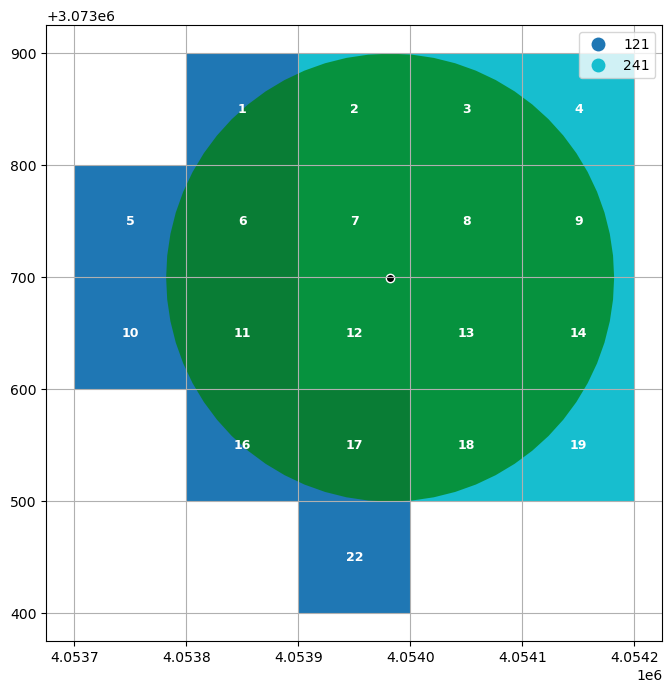

In [17]:
import matplotlib.pyplot as plt
import geopandas as gpd

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

jdf.plot(ax=ax, column="CODE_18", legend=True)

buffer.plot(ax=ax, color='green', alpha = 0.7)
gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").plot(ax=ax, color='black', edgecolor='white')
plt.grid()
for idx, row in jdf.iterrows():
    # Get square center
    centroid_x = row.geometry.centroid.x
    centroid_y = row.geometry.centroid.y
    
    ax.annotate(
        text=str(idx),
        xy=(centroid_x, centroid_y),
        ha='center',
        va='center',
        fontsize=9,
        color='white',
        fontweight='bold'
    )
plt.show()

In [18]:
def plotRecord(geodataframe, buffer):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    geodataframe.plot(ax=ax, column="CODE_18", legend=True)

    buffer.plot(ax=ax, color='green', alpha = 0.7)
    gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").plot(ax=ax, color='black', edgecolor='white')
    plt.grid()
    for idx, row in geodataframe.iterrows():
        # Get square center
        centroid_x = row.geometry.centroid.x
        centroid_y = row.geometry.centroid.y
        
        ax.annotate(
            text=str(idx),
            xy=(centroid_x, centroid_y),
            ha='center',
            va='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )
    return fig

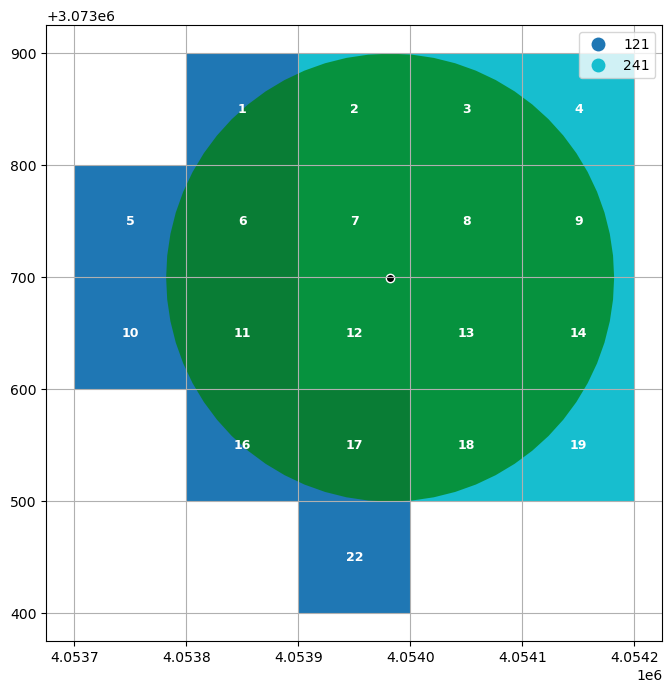

In [19]:
fig = plotRecord(jdf, buffer)

In [20]:
grs= jdf[["value", "geometry"]].groupby("value").count()
grs

,geometry
value,
2,8
18,11
